#Zasoby

* Create a k-means model to cluster London bicycle hires dataset

* https://cloud.google.com/bigquery/docs/e2e-journey

* https://cloud.google.com/bigquery/docs/kmeans-tutorial

* Zapytania opisane w tym samouczku korzystają z funkcji geograficznych dostępnych w analizach geoprzestrzennych. Więcej informacji na temat analityki geoprzestrzennej można znaleźć w sekcji https://cloud.google.com/bigquery/docs/geospatial-intro

- K-means models https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-kmeans

#Cele

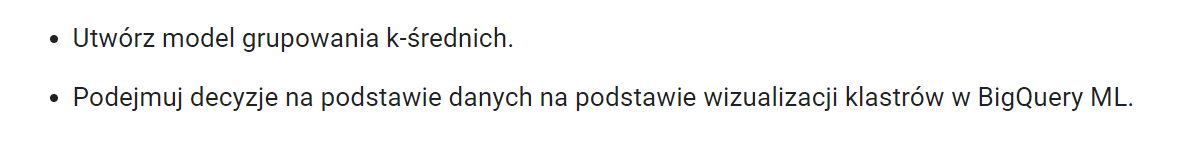

#Sprawdź swoje dane treningowe (Krok 1)

* Zapytanie wykorzystuje również funkcje `ST_DISTANCE` i `ST_GEOGPOINT` analizy geoprzestrzennej.

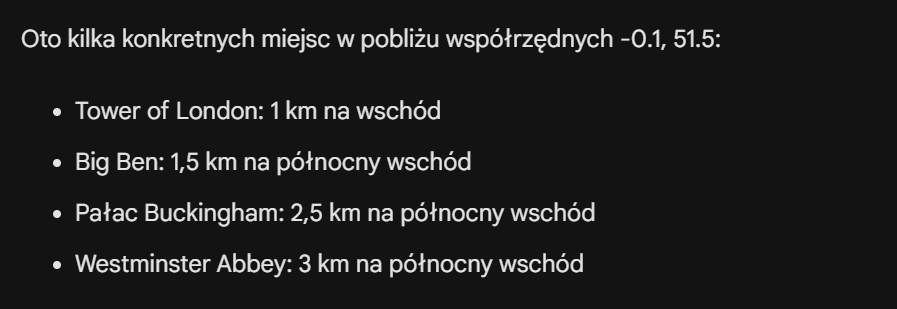

In [ ]:
%%bigquery

  SELECT
    h.start_station_name AS station_name,
    IF(EXTRACT(DAYOFWEEK FROM h.start_date) = 1 OR EXTRACT(DAYOFWEEK FROM h.start_date) = 7, "weekend", "weekday") AS isweekday,
    h.duration,

    # Dystans pomiędzy stacją, a centrum Londynu (-0.1, 51.5)
    ST_DISTANCE(ST_GEOGPOINT(s.longitude, s.latitude), ST_GEOGPOINT(-0.1, 51.5))/1000 AS distance_from_city_center

  FROM
    `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN
    `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON
    h.start_station_id = s.id

  WHERE
    h.start_date BETWEEN CAST('2015-01-01 00:00:00' AS TIMESTAMP) AND CAST('2016-01-01 00:00:00' AS TIMESTAMP)

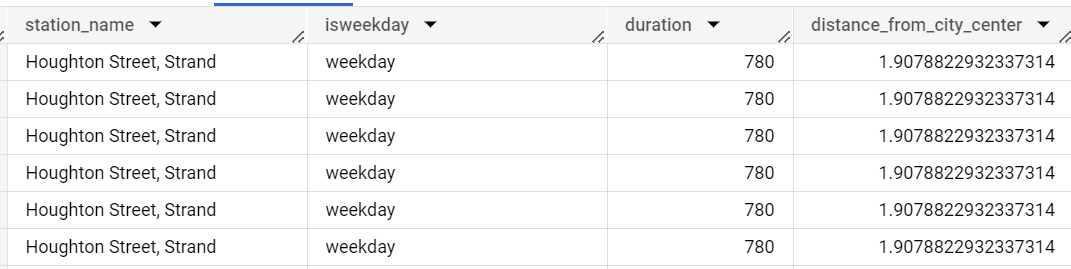

In [ ]:
%%bigquery


WITH hs AS (
  SELECT
    h.start_station_name AS station_name,
    IF(EXTRACT(DAYOFWEEK FROM h.start_date) = 1 OR EXTRACT(DAYOFWEEK FROM h.start_date) = 7, "weekend", "weekday") AS isweekday,
    h.duration,

    # Dystans pomiędzy stacją, a centrum Londynu (-0.1, 51.5)
    ST_DISTANCE(ST_GEOGPOINT(s.longitude, s.latitude), ST_GEOGPOINT(-0.1, 51.5))/1000 AS distance_from_city_center

  FROM
    `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN
    `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON
    h.start_station_id = s.id

  WHERE
    h.start_date BETWEEN CAST('2015-01-01 00:00:00' AS TIMESTAMP) AND CAST('2016-01-01 00:00:00' AS TIMESTAMP)
),

  stationstats AS (
  SELECT
    station_name,
    AVG(duration) AS duration,
    COUNT(duration) AS num_trips,
    MAX(distance_from_city_center) AS distance_from_city_center
  FROM
    hs
  GROUP BY
    station_name
)

SELECT
  *
FROM
  stationstats
ORDER BY
  distance_from_city_center ASC


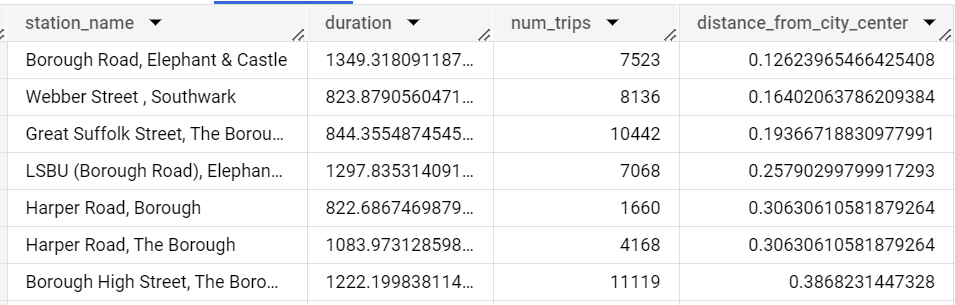

#Utwórz model k-średnich (Krok 2)

##CREATE OR REPLACE MODEL

* Można utworzyć i wytrenować model k-średnich, korzystając z `CREATE MODEL` instrukcji z opcją `model_type=kmeans`

* Aby określić optymalną liczbę skupień, należy uruchomić zapytanie `CREATE MODEL` dla różnych wartości `num_clusters`, znaleźć miarę błędu i wybrać punkt, w którym miara błędu osiąga minimalną wartość. Miarę błędu można uzyskać, wybierając model i klikając kartę Ocena. Na tej karcie wyświetlany jest indeks Daviesa – Bouldina.

* Zmieniając `MAX_ITERATIONS=50` na domyślne `20` poprawiłem index `Indeks Daviesa-Bouldina`

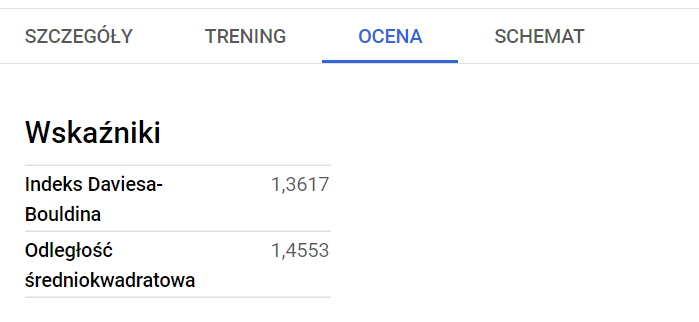

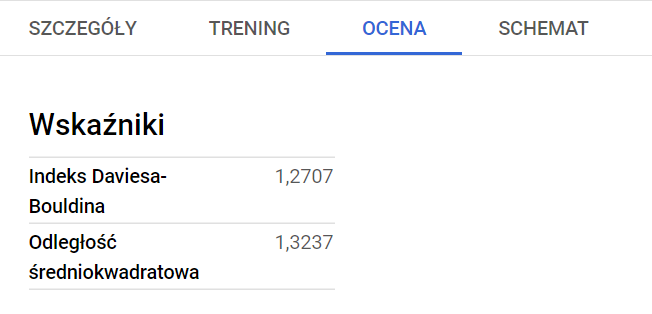

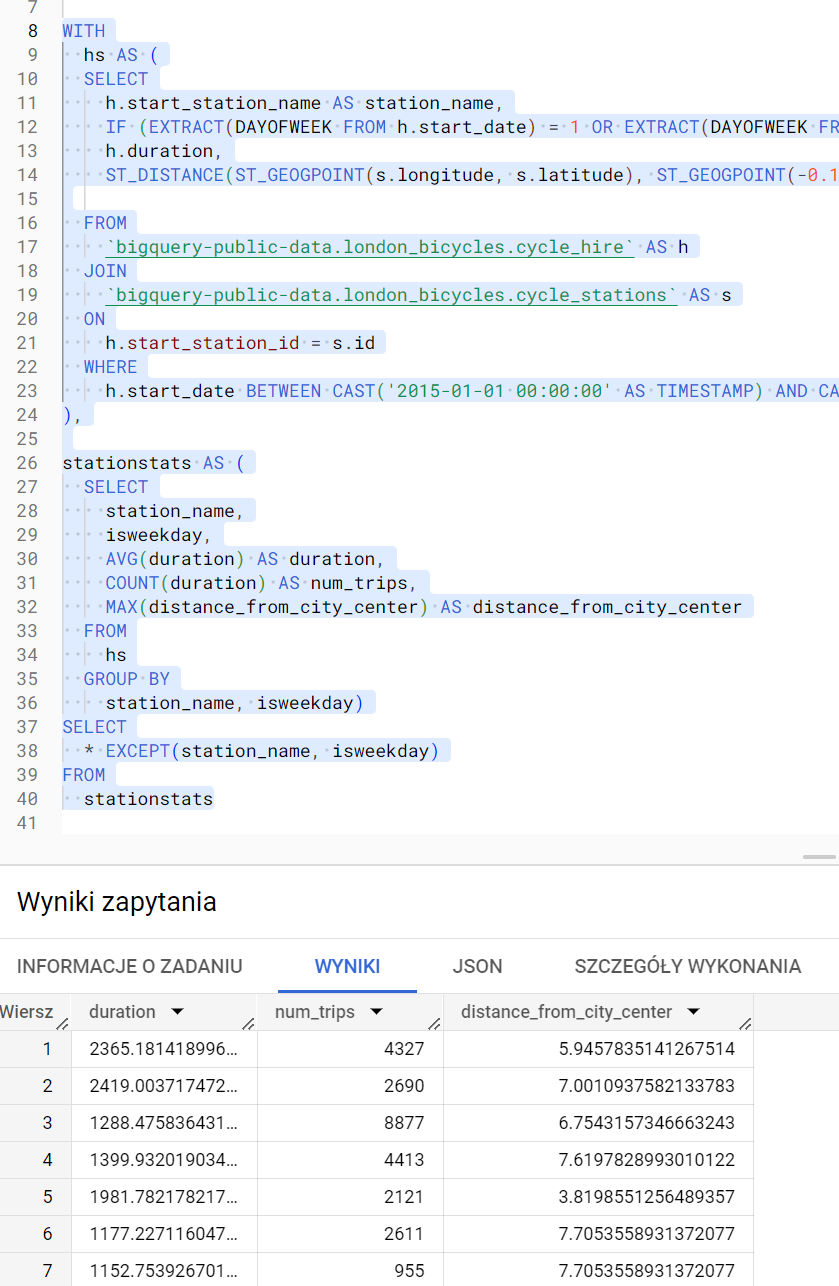

In [ ]:
%%bigquery

{CREATE MODEL | CREATE MODEL IF NOT EXISTS | CREATE OR REPLACE MODEL}
model_name
[OPTIONS(MODEL_TYPE = { 'KMEANS' },
    NUM_CLUSTERS = int64_value,
    KMEANS_INIT_METHOD = { 'RANDOM' | 'KMEANS++' | 'CUSTOM' },
    KMEANS_INIT_COL = string_value,
    DISTANCE_TYPE = { 'EUCLIDEAN' | 'COSINE' },
    STANDARDIZE_FEATURES = { TRUE | FALSE },
    MAX_ITERATIONS = int64_value,
    EARLY_STOP = { TRUE | FALSE },
    MIN_REL_PROGRESS = float64_value,
    WARM_START = { TRUE | FALSE }
)];

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  pmackowka_eu.model_0081 OPTIONS (

  model_type='kmeans',
  num_clusters=4,
  MAX_ITERATIONS=50) AS

WITH
  hs AS (
  SELECT
    h.start_station_name AS station_name,
    IF (EXTRACT(DAYOFWEEK FROM h.start_date) = 1 OR EXTRACT(DAYOFWEEK FROM h.start_date) = 7, "weekend", "weekday") AS isweekday,
    h.duration,
    ST_DISTANCE(ST_GEOGPOINT(s.longitude, s.latitude), ST_GEOGPOINT(-0.1, 51.5))/1000 AS distance_from_city_center

  FROM
    `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN
    `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON
    h.start_station_id = s.id
  WHERE
    h.start_date BETWEEN CAST('2015-01-01 00:00:00' AS TIMESTAMP) AND CAST('2016-01-01 00:00:00' AS TIMESTAMP)
),

stationstats AS (
  SELECT
    station_name,
    isweekday,
    AVG(duration) AS duration,
    COUNT(duration) AS num_trips,
    MAX(distance_from_city_center) AS distance_from_city_center
  FROM
    hs
  GROUP BY
    station_name, isweekday)
SELECT
  * EXCEPT(station_name, isweekday)
FROM
  stationstats

* W obszarze Funkcje liczbowe wykresy słupkowe wyświetlają do 10 najważniejszych wartości funkcji numerycznych dla każdej centroidy.

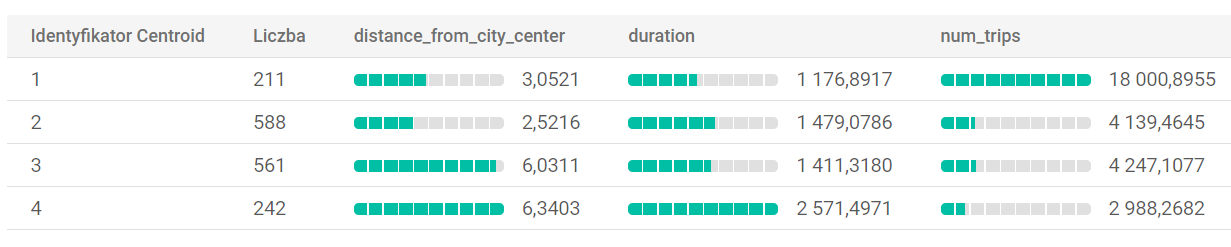

# Użyj funkcji do przewidzenia skupienia stacji (Krok 3)

##ML.PREDICT

* Aby zidentyfikować klaster, do którego należy dana stacja, należy skorzystać z `ML.PREDICT` funkcji.
* To zapytanie używa `REGEXP_CONTAINS` funkcji, aby znaleźć wszystkie wpisy w `station_name` kolumnie zawierające ciąg `„Kennington”`. Funkcja `ML.PREDICT` wykorzystuje te wartości do przewidywania, które klastry będą zawierać te stacje.

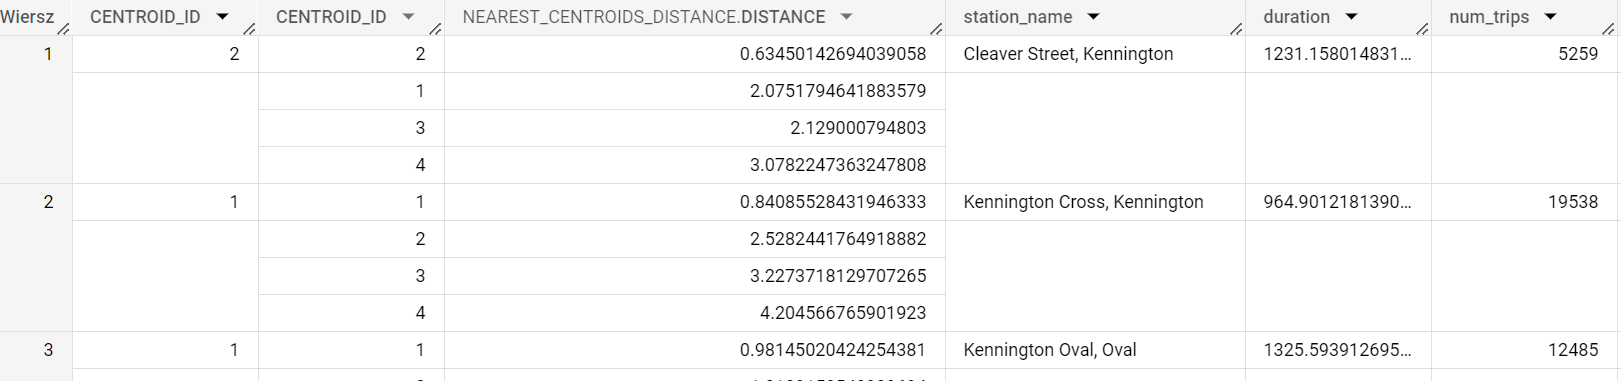

In [ ]:
%%bigquery

WITH
  hs AS (
  SELECT
    h.start_station_name AS station_name,
    IF (EXTRACT(DAYOFWEEK FROM h.start_date) = 1 OR EXTRACT(DAYOFWEEK FROM h.start_date) = 7, "weekend", "weekday") AS isweekday,
    h.duration,
    ST_DISTANCE (ST_GEOGPOINT(s.longitude, s.latitude), ST_GEOGPOINT(-0.1, 51.5))/1000 AS distance_from_city_center

  FROM
    `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN
    `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON
    h.start_station_id = s.id
  WHERE
    h.start_date BETWEEN CAST('2015-01-01 00:00:00' AS TIMESTAMP) AND CAST('2016-01-01 00:00:00' AS TIMESTAMP)
),

  stationstats AS (
  SELECT
    station_name,
    AVG(duration) AS duration,
    COUNT(duration) AS num_trips,
    MAX(distance_from_city_center) AS distance_from_city_center
  FROM
    hs
  GROUP BY
    station_name
)

SELECT
  * EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT( MODEL pmackowka_eu.model_0082,

    (
    SELECT
      *
    FROM
      stationstats
    WHERE
      REGEXP_CONTAINS(station_name, 'Kennington'))
)

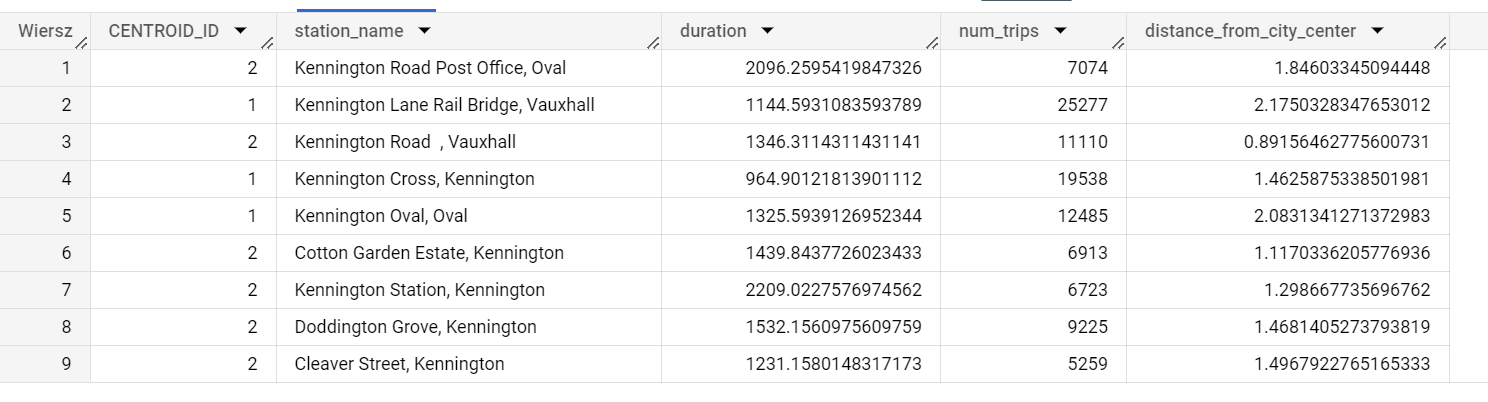

#Wykorzystaj swój model do podejmowania decyzji w oparciu o dane (Krok 4)

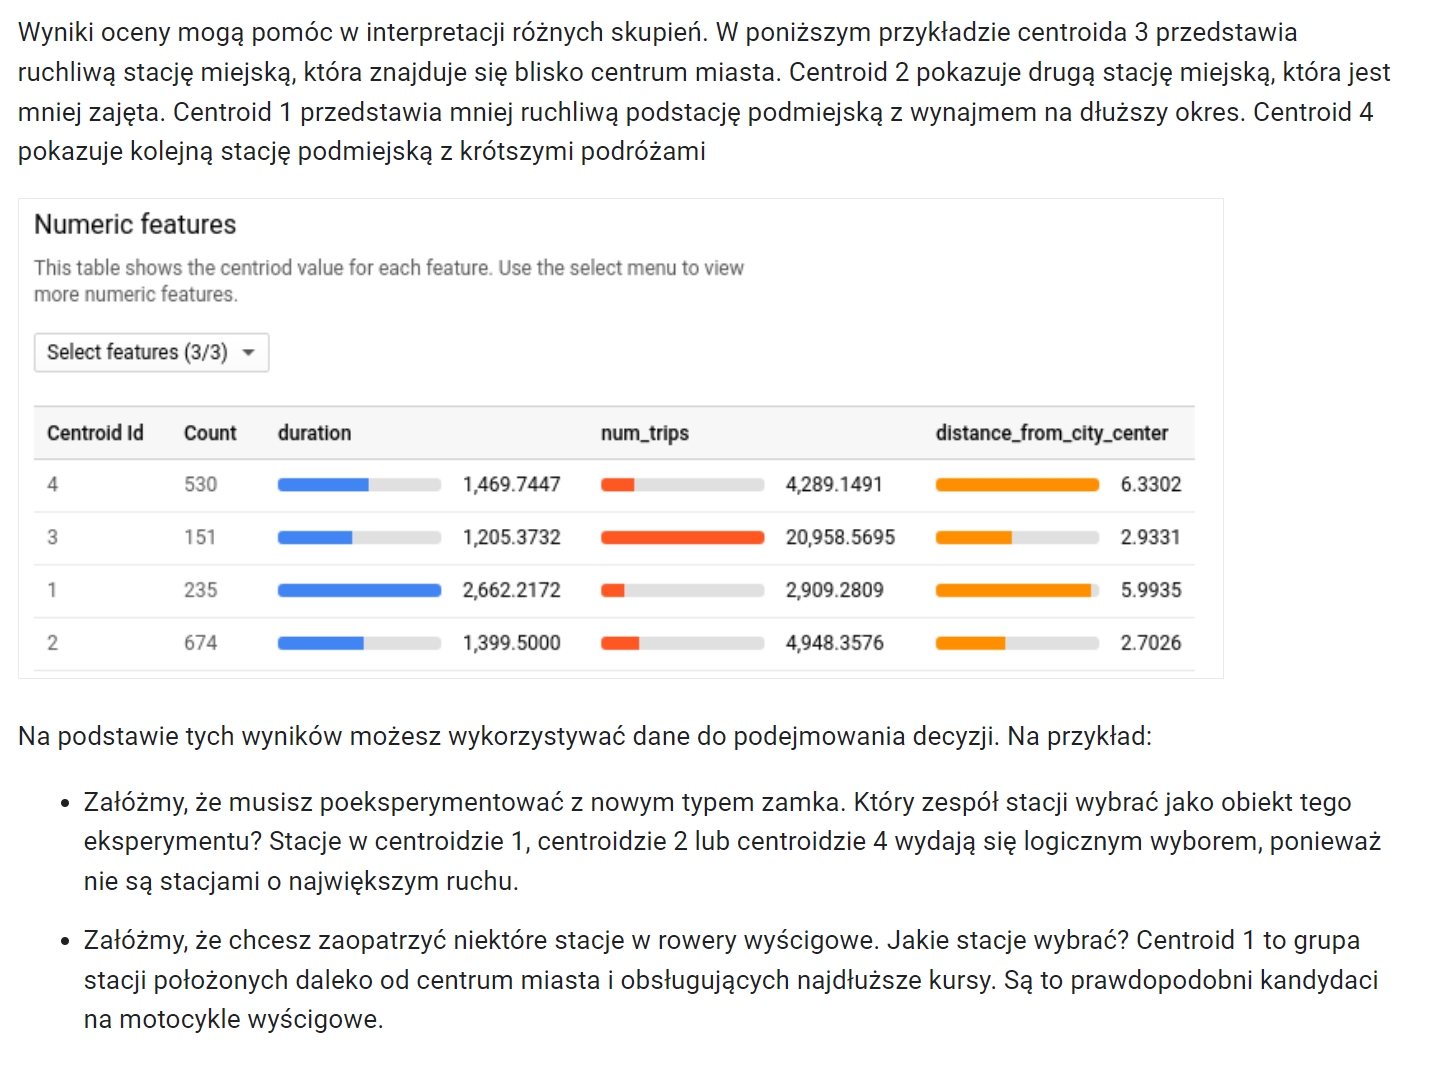